In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing
sb.set()

Datasets
===============

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
steamChart = pd.read_csv('steam_data/steamCharts.csv')
steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
steamCombinedReviews = pd.concat(steamReviewsDF)

C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (3,4,7,12,13,14,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Ed

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})

#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamCombinedReviews['title'] = hero.clean(steamCombinedReviews['title'], pipeline = custom_pipeline)
steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)

Matching Titles with Prices and merging into 1 dataset
===============

In [4]:
steamGames_price = steamGames[['title', 'original_price']]
steamCombinedReviews_Title = steamCombinedReviews[['title']]
matchTitle1 = steamGames_price.title.isin(steamCombinedReviews_Title.title)
steamMatchTitle1 = steamGames_price[matchTitle1]

steamUniqueTitle1 = steamMatchTitle1.drop_duplicates(['title'])
steamUniqueTitle1 = steamUniqueTitle1.reset_index(drop=True)

steamUniqueTitle1
nan_value = float("NaN")
steamUniqueTitle1.replace("", nan_value, inplace=True)
steamUniqueTitle1.dropna(subset = ["title"], inplace=True)
steamUniqueTitle1

,title,original_price
0,playerunknown s battlegrounds,$29.99
1,battletech,$39.99
2,dayz,$44.99
3,human fall flat,$14.99
4,they are billions,$29.99
...,...,...
133,atlas,$29.99
134,metro exodus,$24.99
135,transport fever 2,$38.99
136,halo the master chief collection,$49.99


Extracting titles and review count
===============

In [5]:
steam_reviewsbytitle = pd.DataFrame(steamCombinedReviews.groupby('title').count())
steam_reviewsbytitle.reset_index(level=0, inplace=True)

#extracting only title and number of reviews from dataset and cleaning anomaly

steam_reviewsbytitleonly = steam_reviewsbytitle[['title','review']]
reviews_bytitle=steam_reviewsbytitleonly.drop([0, 0])
reviews_bytitle

,title,review
1,7 days to die,51366
2,age of empires ii definitive edition,20110
3,age of empires ii hd,29614
4,age of empires iii 2007,9697
5,age of mythology extended edition,399
...,...,...
174,town of salem,18151
175,transport fever 2,2925
176,warhammer vermintide 2,20048
177,wasteland 3,3053


Matching prices with titles and review
===============

In [6]:
#matching the 2 datasets together
merged_data1 = pd.merge(steamUniqueTitle1, reviews_bytitle)

merged_data1['original_price'] = merged_data1['original_price'].replace('[\$]', '', regex=True).astype(float)

merged_data1

,title,original_price,review
0,playerunknown s battlegrounds,29.99,236366
1,battletech,39.99,10585
2,dayz,44.99,106062
3,human fall flat,14.99,14391
4,they are billions,29.99,12010
...,...,...,...
132,atlas,29.99,16546
133,metro exodus,24.99,10055
134,transport fever 2,38.99,2925
135,halo the master chief collection,49.99,199


Plotting number of reviews against price in linear regression
===============

In [7]:
price = pd.DataFrame(merged_data1['original_price'])
numreviews = pd.DataFrame(merged_data1['review'])

price_train = pd.DataFrame(price[:100])
numreviews_train = pd.DataFrame(numreviews[:100])

price_test = pd.DataFrame(price[-37:])
numreviews_test = pd.DataFrame(numreviews[-37:])

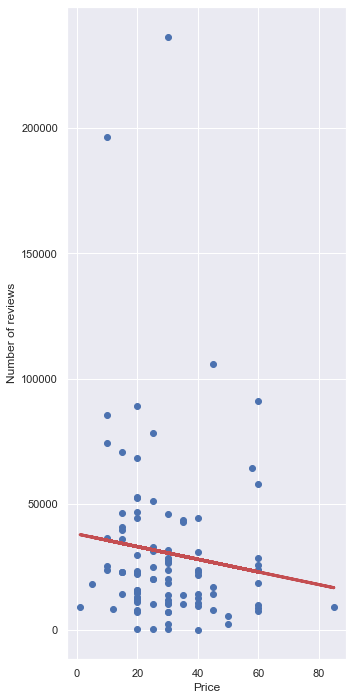

In [8]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(price_train, numreviews_train)

regline_x = price_train
regline_y = linreg.intercept_ + linreg.coef_ * price_train

f = plt.figure(figsize=(5, 12))
plt.scatter(price_train, numreviews_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.xlabel('Price')
plt.ylabel('Number of reviews')
plt.show()

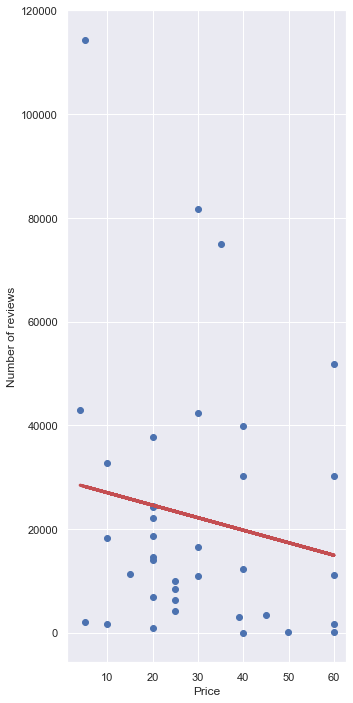

In [9]:
linreg.fit(price_test, numreviews_test)

regline_x = price_test
regline_y = linreg.intercept_ + linreg.coef_ * price_test

f = plt.figure(figsize=(5, 12))
plt.scatter(price_test, numreviews_test)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.xlabel('Price')
plt.ylabel('Number of reviews')
plt.show()

There seems to be many reviews made at the higher price points above 40 dollars since AAA titles are mostly released around that price and are hyped up by their long periods and high cost of development.

However, most of the games are priced below 30 dollars, as seen by the number of dots around that region. And the reception is also good as many reviews are made with some big anomalies at that range.

Hence, we should price the game below 30 dollars or even lower to be receptive to gamers and be price competitively among the other games

Extracting playtime from dataset
===============

Median playtime is used here rather than average playtime as there can be large anomalies.

Since the playtime calculated from Steam counts when the game is open irregardless of whether the game is played or not.

For example some players forgets to close their games leading to very high playtime numbers but this does not represent what we want for the visualisation.

In [10]:
steamData_playtime = steamData[['name', 'median_playtime']]

print("Number of times a user did not play a game they owned:", 
      len(steamData_playtime[steamData_playtime['median_playtime'] == 0]))

#shows that many players do not actually even start a game that they actually own

Number of times a user did not play a game they owned: 20905


In [11]:
#removing players with 0 playtime from dataframe
steamData_playtime[steamData_playtime!= 0]
cols = ["median_playtime"]
steamData_playtime[cols] = steamData_playtime[cols].replace({'0':np.nan, 0:np.nan})
steamData_playtime.dropna(subset = ["median_playtime"], inplace=True)
steamData_playtime = steamData_playtime.rename(columns={"name": "title"})

steam_playtime = pd.DataFrame(steamData_playtime[['title','median_playtime']])

#Narrowing down the dataset as majority of games have a small population for each interval of playtime and since the dataset is huge, it makes it hard to visualize data clearly.

steam_playtime1 = steam_playtime[steam_playtime['median_playtime'].between(0, 1000)]
steam_playtime1

C:\Education\Study\EE0005\Anaconda\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-11-41da9e1a3627>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamData_playtime.dropna(subset = ["median_playtime"], inplace=True)


,title,median_playtime
0,Counter-Strike,317.0
1,Team Fortress Classic,62.0
2,Day of Defeat,34.0
3,Deathmatch Classic,184.0
4,Half-Life: Opposing Force,415.0
...,...,...
26468,Audica,17.0
26481,KumaKuma Manga Editor,43.0
26681,東方幕華祭 春雪篇 ～ Fantastic Danmaku Festival Part II,154.0
26856,Lovers of Aether,12.0


Text(0.5, 0, 'Median Playtime in minutes')

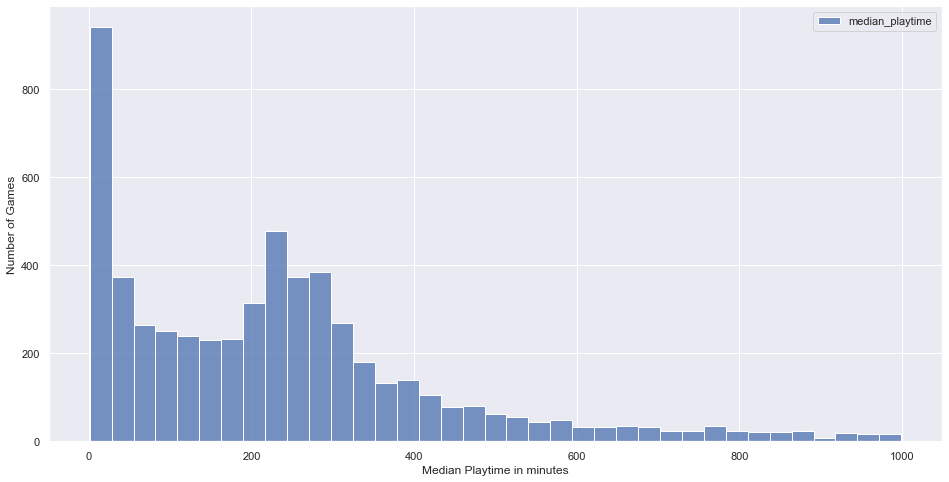

In [12]:
#plot histogram
f = plt.figure(figsize=(16, 8))
sb.histplot(data = steam_playtime1)
plt.ylabel('Number of Games')
plt.xlabel('Median Playtime in minutes')

It can be seen from the histogram that majority of players stops playing the game once it reaches 400 minutes or 6.67 hours of gameplay. Indicating that the longer gameplay reduces interest in the game over time.

It can also be deduced from the histogram that many games are abandoned within the first hour of gameplay, making first impressions all the more important for our game.

Hence we should make a game that is able to provide a good storyline to entice players to play longer. 
Be succinct in gameplay, to avoid players doing repetitive tasks that might cause boredom making them abandon the game quicker.

In [13]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib import dates as mpl_dates
from matplotlib.pyplot import figure
plt.style.use('seaborn')

In [14]:
#selecting year 2020 for only CSGO
counter_strike2020 = steamChart[2:14]

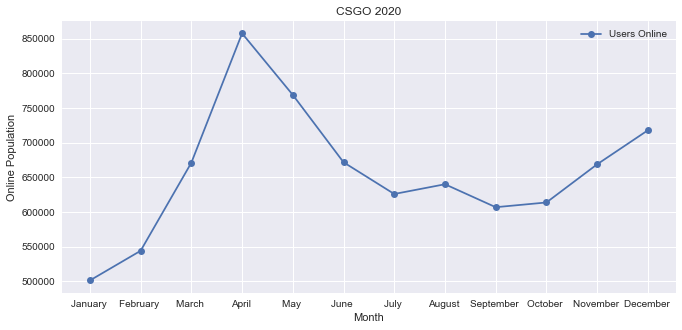

In [15]:
month = counter_strike2020["month"]
users = counter_strike2020["avg"]
plt.figure(figsize=(11,5))
plt.plot_date(month, users, linestyle='solid', label = 'Users Online')
plt.title('CSGO 2020')
plt.xlabel('Month')
plt.ylabel('Online Population')
#had to invert since dataset was in opposite chronological order.
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [16]:
#selecting year 2020 for only Dota2
dota2020 = steamChart[106:118]

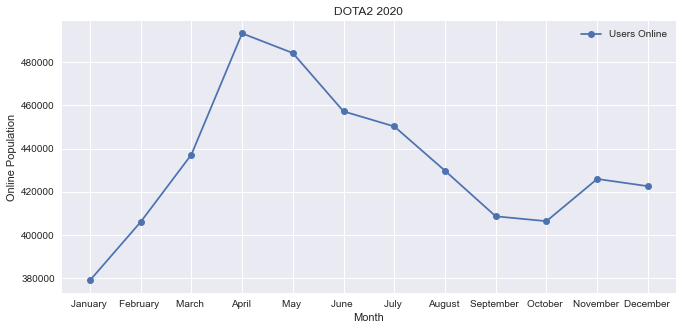

In [17]:
month = dota2020["month"]
users = dota2020["avg"]
plt.figure(figsize=(11,5))
plt.plot_date(month, users, linestyle='solid', label = 'Users Online')
plt.title('DOTA2 2020')
plt.xlabel('Month')
plt.ylabel('Online Population')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

From two of the most popular multiplayer games on Steam, Counter Strike Global Offensive and Dota 2, it can be seen that in the year 2020, when the pandemic struck, more people stayed home to game thus the massive spike in April for both games. 

So we cannot consider this special year to decide when to release our game. 

Instead lets look at 2019 a more "normal" year.

In [18]:
counter_strike2019 = steamChart[14:26]

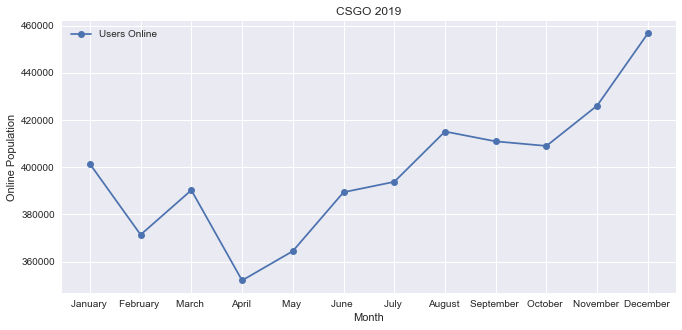

In [19]:
month = counter_strike2019["month"]
users = counter_strike2019["avg"]
plt.figure(figsize=(11,5))
plt.plot_date(month, users, linestyle='solid', label = 'Users Online')
plt.title('CSGO 2019')
plt.xlabel('Month')
plt.ylabel('Online Population')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [20]:
dota2019 = steamChart[118:130]

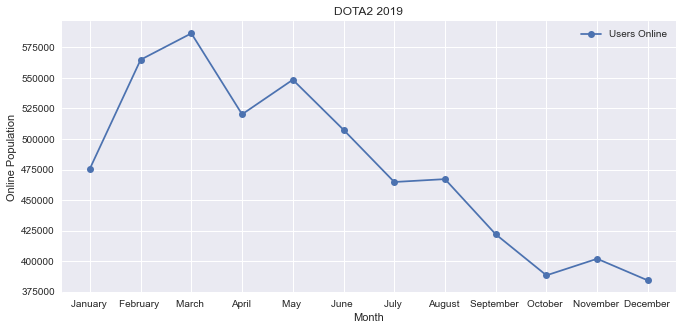

In [21]:
month = dota2019["month"]
users = dota2019["avg"]
plt.figure(figsize=(11,5))
plt.plot_date(month, users, linestyle='solid', label = 'Users Online')
plt.title('DOTA2 2019')
plt.xlabel('Month')
plt.ylabel('Online Population')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In the more normal year of 2019, it can be seen in the month of March has the highest number of active players for both games combined. 

We should start marketing our games starting around the holiday season (November or December) leading up to March to garner hype for the game before release.

Thus, March would be the ideal month for us to release our game to maximise exposure to the number of gamers.